This notebook is used to assess the p-value distributions from the SPIA tests

In [1]:
import getpass
import itertools as itt
import json
import os
import sys
import time
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

from pathway_forte.mappings import (
    get_equivalent_mappings_dict, 
    remap_comparison_df, 
    get_equivalent_mapping_paired_test,
    get_mlp_distribution_tests,
)

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:39) 
[Clang 10.0.0 (clang-1000.11.45.5)]


In [5]:
print(time.asctime())

Mon May 27 15:59:26 2019


In [6]:
print(getpass.getuser())

cthoyt


In [7]:
equivalent_mappings_dict = get_equivalent_mappings_dict()

In [8]:
output = os.path.join(os.path.expanduser('~'), 'Desktop', 'pf_results', 'output')

In [9]:
databases = ['kegg', 'wikipathways', 'reactome']
datasets = ['BRCA', 'KIRC', 'LIHC', 'PRAD']
prefixes = {
    'kegg': 'hsa', 
    'wikipathways': 'WP',
    'reactome':'R-HSA',
}

output_directory = os.path.join(output, 'ks')
os.makedirs(output_directory, exist_ok=True)

In [10]:
def name_to_database(name):
    for database, prefix in prefixes.items():
        if name.startswith(prefix):
            return database

In [11]:
def mlp(x):
    return -np.log10(x)

In [14]:
def draw_mlp_distributions(df, method, savefig_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))

    for dataset, ax in zip(datasets, axes.ravel()):
        ax.set_title(dataset, fontdict=dict(fontsize=16))
        sns.violinplot(
            data=df[df.dataset == dataset],
            y='mlp',
            x='comparison',
            hue='db',
            ax=ax,
        )
        ax.set_ylabel('Minus-log $p$-$value$')
        ax.set_xlabel('')

    plt.tight_layout()
    plt.suptitle(f'{method}: distributions of minus-log $p$-$values$', y=1.06, fontsize=22)

# ORA

In [12]:
ora_directory = os.path.join(output, 'ora')
assert os.path.exists(ora_directory)

In [13]:
ora_dfs = []

for dataset in datasets:
    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(ora_directory, f'ora_geometric_{db1}_{db2}_{dataset.lower()}.tsv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, sep='\t')
        df['comparison'] = f'{db1}_{db2}'
        df['db'] = df['pathway_id'].map(name_to_database)
        df['dataset'] = dataset
        ora_dfs.append(df)
        
if not ora_dfs:
    raise RuntimeError(f'Did not find any ORA files in {ora_directory}')

ora_df = pd.concat(ora_dfs)
ora_df['mlp'] = ora_df.pval.map(mlp)
ora_df.head()

,pathway_id,pval,qval,comparison,db,dataset,mlp
0,hsa00020,0.010393,0.022586,kegg_reactome,kegg,BRCA,1.983240
1,hsa00310,0.001123,0.003732,kegg_reactome,kegg,BRCA,2.949656
2,hsa00562,0.001431,0.004399,kegg_reactome,kegg,BRCA,2.844279
3,R-HSA-428157,0.020046,0.038689,kegg_reactome,reactome,BRCA,1.697968
4,hsa00620,0.000693,0.002527,kegg_reactome,kegg,BRCA,3.159120


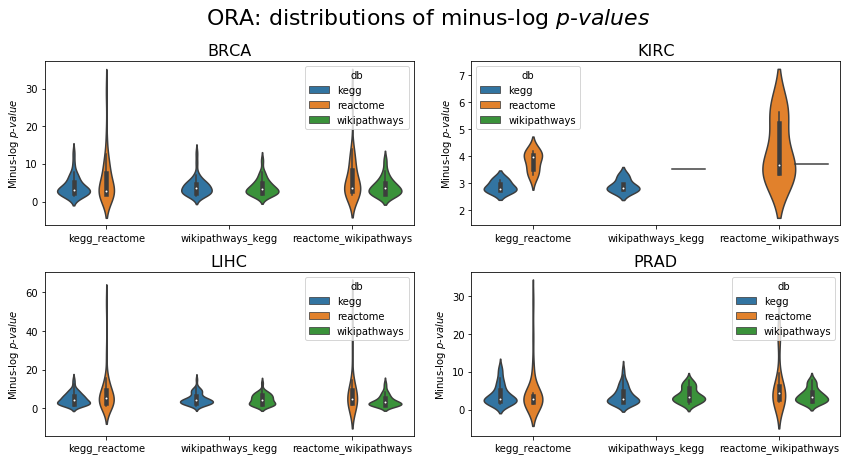

In [15]:
draw_mlp_distributions(ora_df, 'ORA')
plt.savefig(os.path.join(output_directory, 'ora_p_value_distributions.png'))
plt.show()

In [16]:
ora_ks_df = get_mlp_distribution_tests(
    ora_df, 
    datasets,
    identifier_column_name='pathway_id',
    db_column_name='db',
    pval_column_name='pval',
    equivalent_mappings_dict=equivalent_mappings_dict,
)
ora_ks_df['method'] = 'ora'
ora_ks_df.to_csv(os.path.join(output_directory, 'ora_p_values.tsv'), sep='\t', index=False)
ora_ks_df

,dataset,comparison,ks_p,wilcoxon_p,wilcoxon_mlp,ks_paired_mlp_p,ks_paired_mlp_mlp,wilcoxon_significant,ks_paired_mlp_significant,method
0,BRCA,kegg_reactome,0.432213,0.364302,0.610589,1.666552e-13,12.778181,False,True,ora
1,BRCA,wikipathways_kegg,0.981955,0.007908,0.361269,7.783167e-06,5.108844,True,True,ora
2,BRCA,reactome_wikipathways,0.305373,0.515170,0.000286,8.840099e-23,22.053543,False,True,ora
3,KIRC,kegg_reactome,0.014489,1.838971,0.108809,0.000000e+00,inf,False,True,ora
4,KIRC,wikipathways_kegg,0.150366,0.822852,0.317311,0.000000e+00,inf,False,True,ora
5,KIRC,reactome_wikipathways,0.886795,0.052177,0.027708,0.000000e+00,inf,False,True,ora
6,LIHC,kegg_reactome,0.379118,0.421226,0.374056,4.734729e-20,19.324705,False,True,ora
7,LIHC,wikipathways_kegg,0.218447,0.660654,0.141315,1.788843e-04,3.747428,False,True,ora
8,LIHC,reactome_wikipathways,0.080109,1.096316,0.000289,2.508270e-22,21.600626,False,True,ora
9,PRAD,kegg_reactome,0.736750,0.132680,0.015134,3.324978e-18,17.478211,False,True,ora


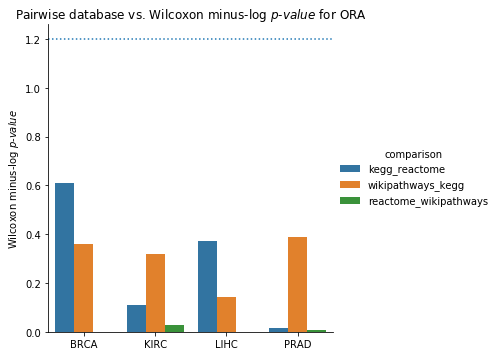

In [17]:
sns.catplot(
    data=ora_ks_df,
    y='wilcoxon_mlp',
    x='dataset',
    kind='bar',
    hue='comparison',
)
plt.axhline(1.2, linestyle=':')
plt.ylabel('Wilcoxon minus-log $p$-$value$')
plt.xlabel('')
plt.title('Pairwise database vs. Wilcoxon minus-log $p$-$value$ for ORA')
plt.savefig(os.path.join(output_directory, 'ora_p_value_statistics.png'))
plt.show()

# GSEA

In [18]:
gsea_directory = os.path.join(output, 'gsea')
assert os.path.exists(gsea_directory)

In [19]:
gsea_dfs = []

for dataset in datasets:
    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(gsea_directory, f'{db1}_{db2}_{dataset.lower()}.tsv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, sep='\t')
        df['comparison'] = f'{db1}_{db2}'
        df['db'] = df['Term'].map(name_to_database)
        df['dataset'] = dataset
        gsea_dfs.append(df)

N_GSEA_PERMUTATIONS = 500
gsea_df = pd.concat(gsea_dfs)
gsea_df['mlp'] = gsea_df.pval.map(lambda x: mlp(x) if x > 0.0 else np.log(N_GSEA_PERMUTATIONS))
del gsea_df['genes']
del gsea_df['ledge_genes']
gsea_df.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,comparison,db,dataset,mlp
0,hsa03030,-0.511916,-1.428605,0.040000,0.286401,36,36,kegg_wikipathways,kegg,BRCA,1.397940
1,WP2828,-0.360112,-1.450696,0.145833,0.288069,41,40,kegg_wikipathways,wikipathways,BRCA,0.836143
2,hsa03050,-0.431336,-1.361182,0.058824,0.308791,45,45,kegg_wikipathways,kegg,BRCA,1.230449
3,WP4022,-0.325892,-1.343728,0.166667,0.311189,86,84,kegg_wikipathways,wikipathways,BRCA,0.778151
4,WP183,-0.405517,-1.376865,0.185185,0.320513,64,62,kegg_wikipathways,wikipathways,BRCA,0.732394


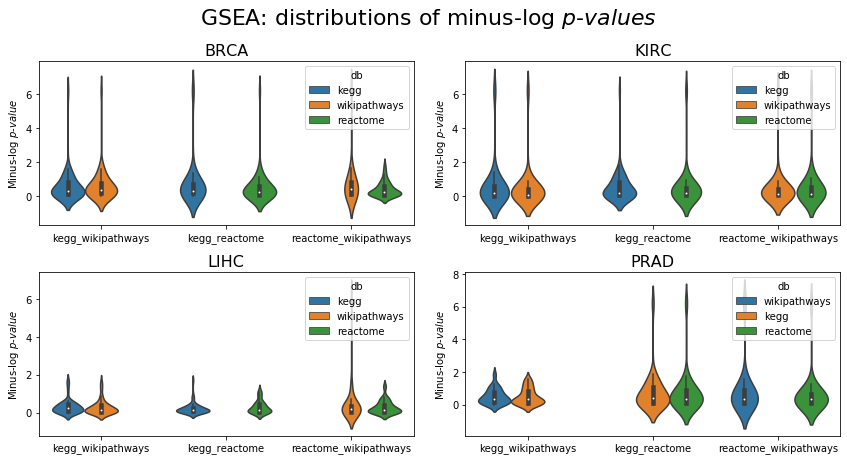

In [20]:
draw_mlp_distributions(gsea_df, 'GSEA')
plt.savefig(os.path.join(output_directory, 'gsea_p_value_distributions.png'))
plt.show()

In [21]:
gsea_ks_df = get_mlp_distribution_tests(
    gsea_df, 
    datasets,
    identifier_column_name='Term',
    pval_column_name='pval',
    equivalent_mappings_dict=equivalent_mappings_dict,
)
gsea_ks_df['method'] = 'gsea'
gsea_ks_df.to_csv(os.path.join(output_directory, 'gsea_p_values.tsv'), sep='\t', index=False)
gsea_ks_df

,dataset,comparison,ks_p,wilcoxon_p,wilcoxon_mlp,ks_paired_mlp_p,ks_paired_mlp_mlp,wilcoxon_significant,ks_paired_mlp_significant,method
0,BRCA,kegg_wikipathways,0.401543,0.396268,0.389451,1.839798e-20,19.735230,False,True,gsea
1,BRCA,kegg_reactome,0.619369,0.208051,0.029370,7.224501e-27,26.141192,False,True,gsea
2,BRCA,reactome_wikipathways,0.371364,0.430201,0.371560,5.716189e-11,10.242893,False,True,gsea
3,KIRC,kegg_wikipathways,0.859989,0.065507,0.001117,NaN,NaN,False,False,gsea
4,KIRC,kegg_reactome,0.474083,0.324146,0.095161,1.513400e-26,25.820046,False,True,gsea
5,KIRC,reactome_wikipathways,0.879095,0.055964,0.170294,NaN,NaN,False,False,gsea
6,LIHC,kegg_wikipathways,0.655476,0.183443,0.048132,2.314013e-32,31.635634,False,True,gsea
7,LIHC,kegg_reactome,0.117687,0.929273,0.596439,7.250610e-21,20.139625,False,True,gsea
8,LIHC,reactome_wikipathways,0.879095,0.055964,0.491281,1.710266e-19,18.766936,False,True,gsea
9,PRAD,kegg_wikipathways,0.951316,0.021675,0.392930,2.967813e-24,23.527563,True,True,gsea


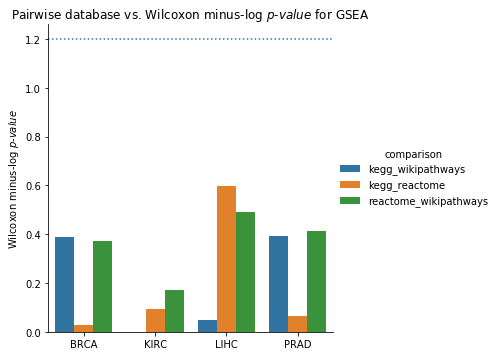

In [22]:
sns.catplot(
    data=gsea_ks_df,
    y='wilcoxon_mlp',
    x='dataset',
    kind='bar',
    hue='comparison',
)
plt.axhline(1.2, linestyle=':')
plt.ylabel('Wilcoxon minus-log $p$-$value$')
plt.xlabel('')
plt.title('Pairwise database vs. Wilcoxon minus-log $p$-$value$ for GSEA')
plt.savefig(os.path.join(output_directory, 'gsea_p_value_statistics.png'))
plt.show()

# SPIA

In [23]:
spia_directory = os.path.join(output, 'spia')

In [24]:
spia_dfs = []

for dataset in datasets:
    for db1, db2 in itt.product(databases, repeat=2):
        path = os.path.join(spia_directory, f'{dataset.lower()}_{db1}_{db2}_spia.csv')
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        df['comparison'] = f'{db1}_{db2}'
        df['db'] = df['Name'].map(name_to_database)
        df['dataset'] = dataset
        spia_dfs.append(df)

spia_df = pd.concat(spia_dfs)
spia_df['mlp'] = spia_df.pG.map(mlp)
spia_df.head()

,Unnamed: 0,Name,ID,pSize,NDE,pNDE,tA,pPERT,pG,pGFdr,pGFWER,Status,KEGGLINK,comparison,db,dataset,mlp
0,1,hsa04151,hsa04151,353,351,2.778553e-23,-153.899612,0.001000,1.662833e-24,1.047585e-22,1.047585e-22,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,kegg,BRCA,23.779151
1,2,hsa04010,hsa04010,294,293,1.550445e-20,-49.666312,0.048000,3.694999e-20,1.163925e-18,2.327850e-18,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,kegg,BRCA,19.432386
2,3,hsa04510,hsa04510,199,199,2.689722e-15,-150.824617,0.000005,6.287952e-19,1.320470e-17,3.961410e-17,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,kegg,BRCA,18.201491
3,4,hsa04810,hsa04810,213,213,2.522745e-16,-54.934581,0.074000,7.377661e-16,1.161982e-14,4.647927e-14,Inhibited,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,kegg,BRCA,15.132081
4,5,hsa04062,hsa04062,188,187,6.145755e-13,4.093045,0.883000,1.586891e-11,1.999483e-10,9.997413e-10,Activated,http://www.genome.jp/dbget-bin/show_pathway?hs...,kegg_wikipathways,kegg,BRCA,10.799453


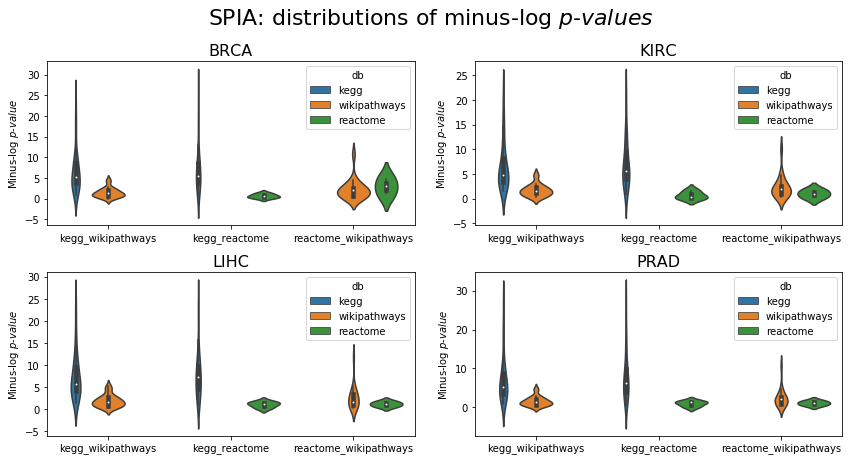

In [25]:
draw_mlp_distributions(spia_df, 'SPIA')
plt.savefig(os.path.join(output_directory, 'spia_p_value_distributions.png'))
plt.show()

In [26]:
spia_ks_df = get_mlp_distribution_tests(
    spia_df, 
    datasets,
    identifier_column_name='Name',
    pval_column_name='pG',
    equivalent_mappings_dict=equivalent_mappings_dict,
)
spia_ks_df['method'] = 'gsea'
spia_ks_df.to_csv(os.path.join(output_directory, 'gsea_p_values.tsv'), sep='\t', index=False)
spia_ks_df

,dataset,comparison,ks_p,wilcoxon_p,wilcoxon_mlp,ks_paired_mlp_p,ks_paired_mlp_mlp,wilcoxon_significant,ks_paired_mlp_significant,method
0,BRCA,kegg_wikipathways,5.156326e-07,6.287660,9.087312e-08,1.858888e-60,59.730747,False,True,gsea
1,BRCA,kegg_reactome,6.610303e-03,2.179779,2.477028e-07,0.000000e+00,inf,False,True,gsea
2,BRCA,reactome_wikipathways,7.244088e-01,0.140016,1.797125e-01,0.000000e+00,inf,False,True,gsea
3,KIRC,kegg_wikipathways,5.156326e-07,6.287660,9.087312e-08,1.858888e-60,59.730747,False,True,gsea
4,KIRC,kegg_reactome,6.610303e-03,2.179779,2.477028e-07,0.000000e+00,inf,False,True,gsea
5,KIRC,reactome_wikipathways,5.212395e-01,0.282963,1.797125e-01,0.000000e+00,inf,False,True,gsea
6,LIHC,kegg_wikipathways,5.402924e-07,6.267371,8.387355e-08,1.858888e-60,59.730747,False,True,gsea
7,LIHC,kegg_reactome,6.610303e-03,2.179779,2.477028e-07,0.000000e+00,inf,False,True,gsea
8,LIHC,reactome_wikipathways,2.954444e-01,0.529524,1.797125e-01,0.000000e+00,inf,False,True,gsea
9,PRAD,kegg_wikipathways,5.156326e-07,6.287660,9.843673e-08,5.109674e-49,48.291607,False,True,gsea


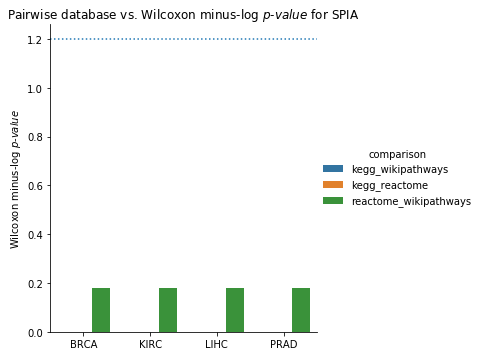

In [27]:
sns.catplot(
    data=spia_ks_df,
    y='wilcoxon_mlp',
    x='dataset',
    kind='bar',
    hue='comparison',
)
plt.axhline(1.2, linestyle=':')
plt.title('Pairwise database vs. Wilcoxon minus-log $p$-$value$ for SPIA')
plt.ylabel('Wilcoxon minus-log $p$-$value$')
plt.xlabel('')
plt.savefig(os.path.join(output_directory, 'spia_p_value_statistics.png'))
plt.show()